In [1]:
import pandas as pd
import numpy as np
import operator

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
import seaborn as sns

import os
import sys
import locale

from pathlib import Path

%matplotlib inline

In [2]:
# Name of file to import raw data from (from bloomberg)
filename = "Norepinephrine Market vRH.xlsx"

# Dynamically create filepath independent of system
path = Path(os.getcwd())
filepath = os.path.abspath(os.path.join(path.parent, "imports", filename))

# appending to sys.path to allow for relative import of general functions
sys.path.append(os.path.abspath(path.parent.parent))
from drug_curves import multi_index_column_rename, pricerx_df_gen

In [3]:
# Importing in data
raw_data = pd.read_excel(filepath, sheet_name="BB New", header=[0, 1, 2])
raw_data.columns = multi_index_column_rename(raw_data.columns)

# Global Important Variables
DRUGS = ["Levophed Bitartrate", "Norepinephrine Bitartrate"]
UNITS = {
    "volume": "Institutional Pack Units",
    "mbs": "Institutional Mbs"
}

# Organizing Data

In [4]:
# Examinine that all date columns match
# Note -- df.duplicated was not working for some reason
idx = pd.IndexSlice[:, :, "Date"]
assert raw_data.loc[:, idx].apply(lambda row: row.duplicated(keep=False).all(), axis=1).sum() == raw_data.shape[0]

# Assert "Date" is a timestmap/datetime dtype
assert pd.core.dtypes.common.is_datetime_or_timedelta_dtype(raw_data.loc[:, idx].iloc[:, 0])

# Push the first "Date Column"
raw_data.set_index(raw_data.loc[:, idx].iloc[:, 0], inplace=True)
raw_data.index.name = "Date"


# Dropping "Date" Columns and ["Blank"] columns [if any]
raw_data.drop("Date", axis=1, level=2, inplace=True)
for level in raw_data.columns:
    if "[Blank]" in level:
        raw_data.drop("[Blank]", axis=1, level=2, inplace=True)
        break

# Dropping rows earlier than 1/31/2013
raw_data = raw_data.loc[raw_data.index >= pd.Timestamp(year=2013, month=1, day=31), :].copy()

# Dropping empty columns
columns_to_drop = []
for column in raw_data:
    if raw_data.loc[:, column].isnull().all():
        columns_to_drop.append(column)
raw_data.drop(columns_to_drop, axis=1, inplace=True)

# Changing column names to match pricerx db
mapper = {"Pfizer/Hospira": "Pfizer",
          "Hospira/Novaplu": "Novation",
          "Amneal Bio": "Amneal",
          "Sandoz Inc": "Sandoz",
          "Sicor Pharma": "Teva",
          "Baxter/Claris": "Claris",
          "Hikma/West-Ward": "Hikma",
          "Mylan Instituti": "Mylan",
         }
raw_data.rename(mapper, axis=1, level=2, inplace=True)

# Visualizing our new modified df
raw_data.head()

Total Market                            \
           Institutional Pack Units                             
                Levophed Bitartrate Norepinephrine Bitartrate   
Date                                                            
2019-08-31                  64080.0                  678513.0   
2019-07-31                  60110.0                  667584.0   
2019-06-30                  50320.0                  604311.0   
2019-05-31                  56730.0                  719010.0   
2019-04-30                  74940.0                  693860.0   

                Levophed Bitartrate                                      \
           Institutional Pack Units          Institutional Mbs            
                             Pfizer Novation            Pfizer Novation   
Date                                                                      
2019-08-31                  64080.0      NaN         1296338.4      NaN   
2019-07-31                  60110.0      NaN         1216025.3      NaN   
2019-06-30                  50320.0      NaN         1017973.6      NaN   
2019-05-31                  56730.0      NaN         1147647.9      NaN   
2019-04-30                  74940.0      NaN         1516036.2      NaN   

           Norepinephrine Bitartrate                                        \
            Institutional Pack Units                                         
                              Amneal   Sandoz      Teva    Claris    Hikma   
Date                                                                         
2019-08-31                    1090.0  13140.0   86440.0  439843.0  41510.0   
2019-07-31                     270.0   6830.0   93840.0  442244.0  33090.0   
2019-06-30                       NaN   8560.0   87910.0  403751.0  13370.0   
2019-05-31                       NaN      NaN  111660.0  482600.0  30480.0   
2019-04-30                       NaN      NaN  106610.0  475340.0  25020.0   

                                                                         \
                    Institutional Mbs                                     
              Mylan            Amneal     Sandoz       Teva      Claris   
Date                                                                      
2019-08-31  96490.0           19641.8  239239.98  1557648.8  3848626.25   
2019-07-31  91310.0            4865.4  124353.81  1690996.8  3869635.00   
2019-06-30  90720.0               NaN  155851.92  1584138.2  3532821.25   
2019-05-31  94270.0               NaN        NaN  2012113.2  4222750.00   
2019-04-30  86890.0               NaN        NaN  1921112.2  4159225.00   

                                   
                                   
                Hikma       Mylan  
Date                               
2019-08-31  830781.14  1684618.91  
2019-07-31  662263.26  1594181.29  
2019-06-30  267587.18  1583880.48  
2019-05-31  610026.72  1645859.93  
2019-04-30  500750.28  1517012.51

# Visualizing Missing Data

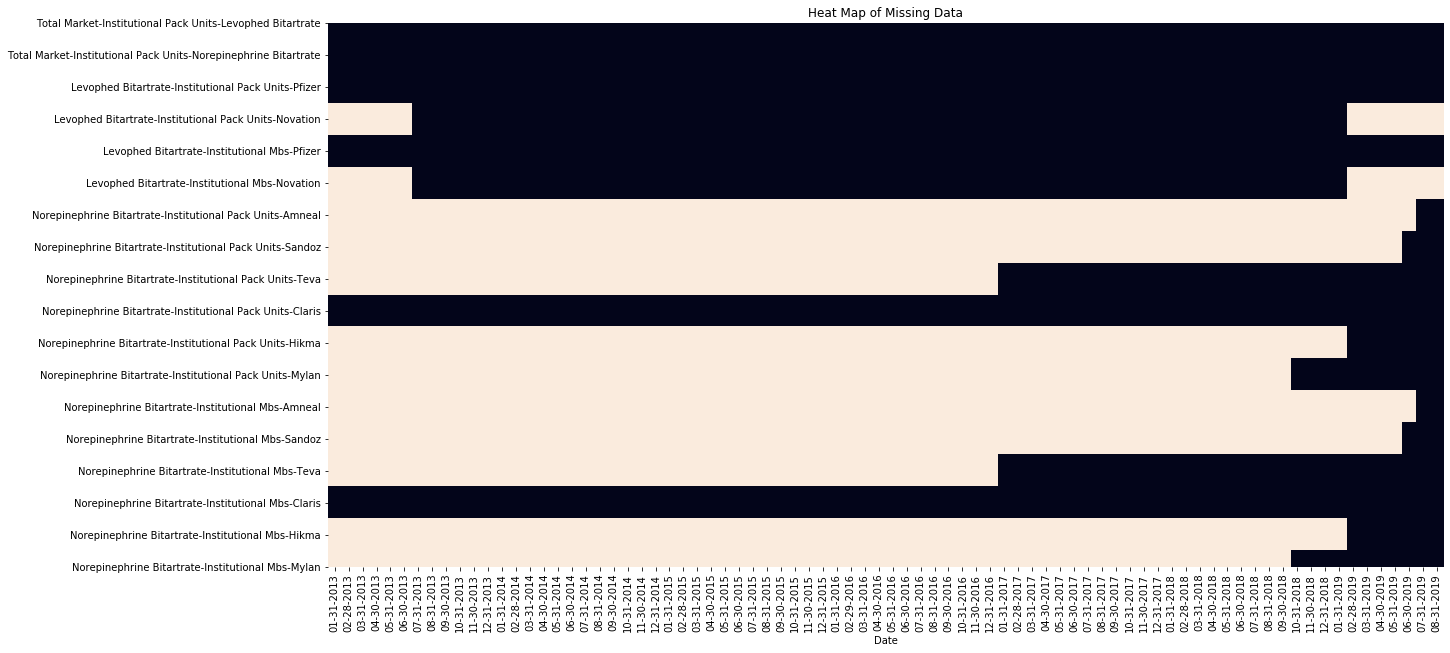

In [5]:
# Visualizing Missing Data
fig = plt.figure(figsize=(20,10))
ax = sns.heatmap(raw_data.isnull().T, cbar=False)
plt.ylabel(None)
title = plt.title("Heat Map of Missing Data")
labels = ax.set_xticklabels(np.array(raw_data.index.map(lambda date: date.strftime('%m-%d-%Y'))))
ax.invert_xaxis()

# Data Validation

In [6]:
# These assertions check that we are capturing the entire drug volume (we breakout by manuf.)
assert (raw_data.loc[:, ("Total Market", "Institutional Pack Units", DRUGS[0])]\
== raw_data.loc[:, (DRUGS[0], "Institutional Pack Units", slice(None))].sum(axis=1)).all()

assert (raw_data.loc[:, ("Total Market", "Institutional Pack Units", DRUGS[1])]\
== raw_data.loc[:, (DRUGS[1], "Institutional Pack Units", slice(None))].sum(axis=1)).all()

# Replacing negative numbers with 0s
raw_data.mask(raw_data < 0, 0, inplace=True)

In [7]:
pricerx_df = pricerx_df_gen(DRUGS)
frames = {}
calculated_df = pd.DataFrame()
report = pd.DataFrame()

# SHOULD TURN THIS TO A GENERAL FUNCTION (TRICK IS TO MAKE IT SPREADABLE ACROSS CURVES)
# different curves will have different levels -- need to make dynamic
for drug in DRUGS:
    all_manufacturers = raw_data.loc[:, drug]
    frames[drug] = {}
    for manufacturer in all_manufacturers.columns.get_level_values(1).unique():
        idx = pd.IndexSlice[:, manufacturer]
        manufacturer_df = all_manufacturers.loc[:, idx].copy()
        manufacturer_df.columns = manufacturer_df.columns.droplevel(level=1)
        manufacturer_df["Drug"] = drug
        manufacturer_df["Manufacturer"] = manufacturer
        
        manufacturer_pricerx = pricerx_df.loc[(pricerx_df["Drug"] == drug) & (pricerx_df["Manufacturer"] == manufacturer), :].copy()
        
        manufacturer_df["Price/Vial"] = (manufacturer_pricerx["Price"] / manufacturer_pricerx["Package"]).astype(float)
        manufacturer_df["Calculated Total"] = manufacturer_df[UNITS["volume"]] * manufacturer_df["Price/Vial"]
        manufacturer_df["Difference"] = round(manufacturer_df["Calculated Total"] - manufacturer_df[UNITS["mbs"]], 2)
        manufacturer_df["Percentage Change"] = round(manufacturer_df["Difference"] / manufacturer_df[UNITS["mbs"]], 2)
        
        frames[drug][manufacturer] = manufacturer_df
        calculated_df = calculated_df.append(manufacturer_df)
        
        report[("{}-{}".format(drug, manufacturer))] = manufacturer_df["Percentage Change"]

def color_negative_red(x):
    if x > 0 or x < 0:
        color = "red"
    else:
        color = "black"
    return 'color: {}'.format(color)

report = report.head(12).style.applymap(color_negative_red)
report

,Levophed Bitartrate-Pfizer,Levophed Bitartrate-Novation,Norepinephrine Bitartrate-Amneal,Norepinephrine Bitartrate-Sandoz,Norepinephrine Bitartrate-Teva,Norepinephrine Bitartrate-Claris,Norepinephrine Bitartrate-Hikma,Norepinephrine Bitartrate-Mylan
Date,,,,,,,,
2019-08-31 00:00:00,0,nan,0,0,0,0,0,0
2019-07-31 00:00:00,0,nan,0,0,0,0,0,0
2019-06-30 00:00:00,0,nan,nan,0,0,0,0,0
2019-05-31 00:00:00,0,nan,nan,nan,0,0,0,0
2019-04-30 00:00:00,0,nan,nan,nan,0,0,-0,0
2019-03-31 00:00:00,0,nan,nan,nan,0,0,0,0
2019-02-28 00:00:00,0,nan,nan,nan,0,0,nan,-0
2019-01-31 00:00:00,0,nan,nan,nan,-0,0,nan,0
2018-12-31 00:00:00,0,nan,nan,nan,0,0,nan,0


# Plotting the Data

## Set up

In [8]:
# Color Map
color_map = {
    "purple": (112, 48, 160),
    "blue": (91, 155, 213),
    "green": (112, 173, 71),
    "yellow": (255, 192, 0),
    "orange": (237, 125, 49),
    "grey": (128, 128, 128),
    "blue-grey": (51, 63, 79),
    "black": (89, 89, 89),
    "red": (192, 0, 0)
}
adj_color_map = {}
for key, value in color_map.items():
    adj_color_map[key] = tuple(c/255 for c in value)
    
# Globally setting the linewidth
matplotlib.rcParams['lines.linewidth'] = 3
matplotlib.rcParams['font.family'] = "Open Sans"
matplotlib.rcParams['text.color'] = adj_color_map["black"]
matplotlib.rcParams['axes.labelcolor'] = adj_color_map["black"]
matplotlib.rcParams['xtick.color'] = adj_color_map["black"]
matplotlib.rcParams['ytick.color'] = adj_color_map["black"]

locale.setlocale(locale.LC_ALL, '')
def format_fn_volume(tick_val, tick_pos):
    return locale.currency(tick_val, grouping=True).replace(".00", "").replace("$", "")


def format_fn_wac(tick_val, tick_pos):
    return locale.currency(tick_val, grouping=True).replace(".00", "")

## Volume

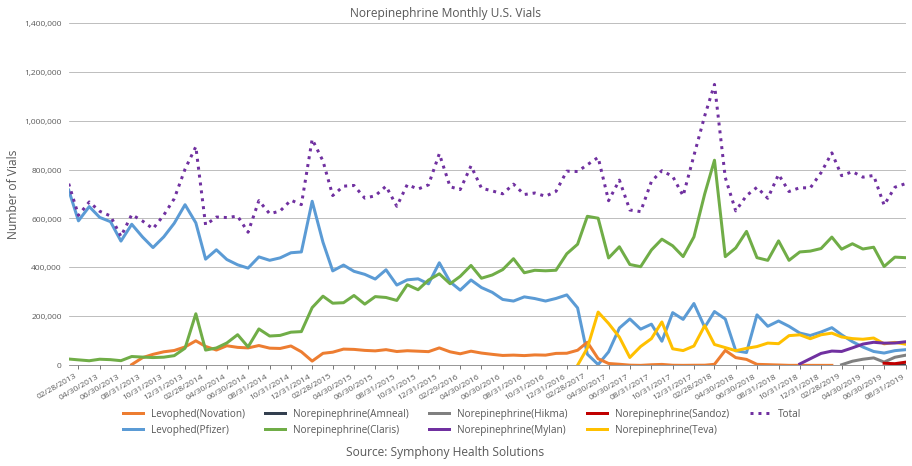

In [28]:
volume = calculated_df.pivot_table(index="Date", columns=["Drug", "Manufacturer"], values=UNITS["volume"])
volume["Total"] = volume.sum(axis=1)

# Setting up figure and axes
fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(1, 1, 1)

# Plotting the data
# Need to make dynamic
levo_p = volume[("Levophed Bitartrate", "Pfizer")]
nor_h = volume[("Norepinephrine Bitartrate", "Hikma")]
levo_n = volume[("Levophed Bitartrate", "Novation")]
nor_a = volume[("Norepinephrine Bitartrate", "Amneal")]
nor_c = volume[("Norepinephrine Bitartrate", "Claris")]
nor_s = volume[("Norepinephrine Bitartrate", "Sandoz")]
nor_t = volume[("Norepinephrine Bitartrate", "Teva")]
total = volume["Total"]
nor_m = volume[("Norepinephrine Bitartrate", "Mylan")]

ax.plot(levo_p, c=adj_color_map["blue"], label="Levophed(Pfizer)")
ax.plot(nor_h, c=adj_color_map["grey"], label="Norepinephrine(Hikma)")
ax.plot(levo_n, c=adj_color_map["orange"], label="Levophed(Novation)")
ax.plot(nor_a, c=adj_color_map["blue-grey"], label="Norepinephrine(Amneal)")
ax.plot(nor_c, c=adj_color_map["green"], label="Norepinephrine(Claris)")
ax.plot(nor_s, c=adj_color_map["red"], label="Norepinephrine(Sandoz)")
ax.plot(nor_t, c=adj_color_map["yellow"], label="Norepinephrine(Teva)")
ax.plot(total, c=adj_color_map["purple"], ls="dotted", label="Total")
ax.plot(nor_m, c=adj_color_map["purple"], label="Norepinephrine(Mylan)")

# Formatting the y axis
ax.set_ylim(0, 1400000)
ax.yaxis.set_major_formatter(FuncFormatter(format_fn_volume))
ax.yaxis.grid(True)

# Formatting the x axis
ax.set_xticks(list(total.index)[::-2])
ax.set_xlim([total.index[0], total.index[-1]])
years_fmt = mdates.DateFormatter("%m/%d/%Y")
ax.xaxis.set_major_formatter(years_fmt)

# Removing spines and ticks (where necessary)
ax.spines["top"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["right"].set_visible(False)

# Adding labels and titles
ax.tick_params(left=False)
ax.set_title("Norepinephrine Monthly U.S. Vials", size="large", position=(.45,1))
ax.set_xlabel("Source: Symphony Health Solutions", labelpad=45, position=(.45,1), size="medium")
ax.set_ylabel("Number of Vials", size="large")

# Reducing axis font and setting x spine color
ax.tick_params(axis='x', labelsize="small")
ax.tick_params(axis='y', labelsize="small")
ax.spines["bottom"].set_color('grey')

# Formatting the date labels
fig.autofmt_xdate()

# Organizing the legend
handles, labels = ax.get_legend_handles_labels()
h = sorted(zip(handles, labels), key=operator.itemgetter(1))
handles2, labels2 = zip(*h)

# Plotting the legend
ax.legend(handles2, labels2, loc="upper center", ncol=5, bbox_to_anchor=(.47,-0.10), frameon=False)

plt.show()

## PriceRx

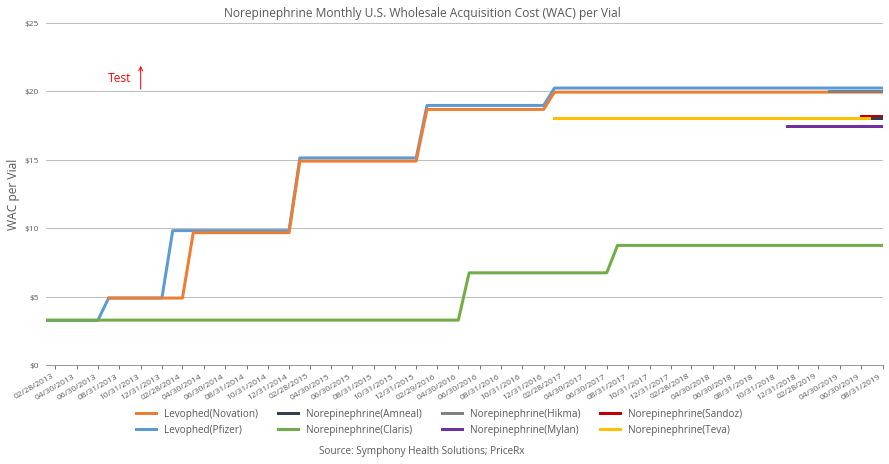

In [29]:
pricerx = calculated_df.pivot_table(index="Date", columns=["Drug", "Manufacturer"], values="Price/Vial")

# Setting up figure and axes
fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(1, 1, 1)

# Plotting the data
# Need to make dynamic
levo_p = pricerx[("Levophed Bitartrate", "Pfizer")]
nor_h = pricerx[("Norepinephrine Bitartrate", "Hikma")]
levo_n = pricerx[("Levophed Bitartrate", "Novation")]
nor_a = pricerx[("Norepinephrine Bitartrate", "Amneal")]
nor_c = pricerx[("Norepinephrine Bitartrate", "Claris")]
nor_s = pricerx[("Norepinephrine Bitartrate", "Sandoz")]
nor_t = pricerx[("Norepinephrine Bitartrate", "Teva")]
nor_m = pricerx[("Norepinephrine Bitartrate", "Mylan")]

ax.plot(levo_p, c=adj_color_map["blue"], label="Levophed(Pfizer)")
ax.plot(levo_n, c=adj_color_map["orange"], label="Levophed(Novation)")
ax.plot(nor_c, c=adj_color_map["green"], label="Norepinephrine(Claris)")
ax.plot(nor_s, c=adj_color_map["red"], label="Norepinephrine(Sandoz)")
ax.plot(nor_t, c=adj_color_map["yellow"], label="Norepinephrine(Teva)")
ax.plot(nor_m, c=adj_color_map["purple"], label="Norepinephrine(Mylan)")
ax.plot(nor_h, c=adj_color_map["grey"], label="Norepinephrine(Hikma)")
ax.plot(nor_a, c=adj_color_map["blue-grey"], label="Norepinephrine(Amneal)")

# Creating percentage changes
# ax.arrow(pd.Timestamp(year=2013, month=10, day=31), 20, 0, 4, arrowstyle="->")
t = pd.Timestamp(year=2013, month=10, day=31)
s = pd.Timestamp(year=2013, month=7, day=28)
q = pd.Timestamp(year=2013, month=4, day=28)

arrowprops = {
    "arrowstyle": "->",
    "ec": "red",
}

ax.text(s, 20.70, "Test", color="red", size=12)
ax.annotate("", xy=(t, 22), xytext=(t, 20), arrowprops=arrowprops)

# Formatting the y axis
ax.set_ylim([0, 25])
ax.yaxis.set_major_formatter(FuncFormatter(format_fn_wac))
ax.yaxis.grid(True)

# Formatting the x axis
ax.set_xticks(list(levo_p.index)[::-2])
ax.set_xlim([levo_p.index[0], levo_p.index[-1]])
years_fmt = mdates.DateFormatter("%m/%d/%Y")
ax.xaxis.set_major_formatter(years_fmt)

# Removing spines and ticks (where necessary)
ax.spines["top"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["right"].set_visible(False)

# Adding labels and titles
ax.tick_params(left=False)
ax.set_title("Norepinephrine Monthly U.S. Wholesale Acquisition Cost (WAC) per Vial", size="large", position=(.45,1))
ax.set_xlabel("Source: Symphony Health Solutions; PriceRx", labelpad=45, position=(.45,1), size="medium")
ax.set_ylabel("WAC per Vial", size="large")

# Reducing axis font and setting x spine color
ax.tick_params(axis='x', labelsize="small")
ax.tick_params(axis='y', labelsize="small")
ax.spines["bottom"].set_color('grey')

# Formatting the date labels
fig.autofmt_xdate()

# Organizing the legend
handles, labels = ax.get_legend_handles_labels()
h = sorted(zip(handles, labels), key=operator.itemgetter(1))
handles2, labels2 = zip(*h)

# Plotting the legend
ax.legend(handles2, labels2, loc="upper center", ncol=4, bbox_to_anchor=(.47,-0.10), frameon=False)

# Showing the plot
plt.show()
# plt.savefig("price_test.pdf")

# Calc Wac

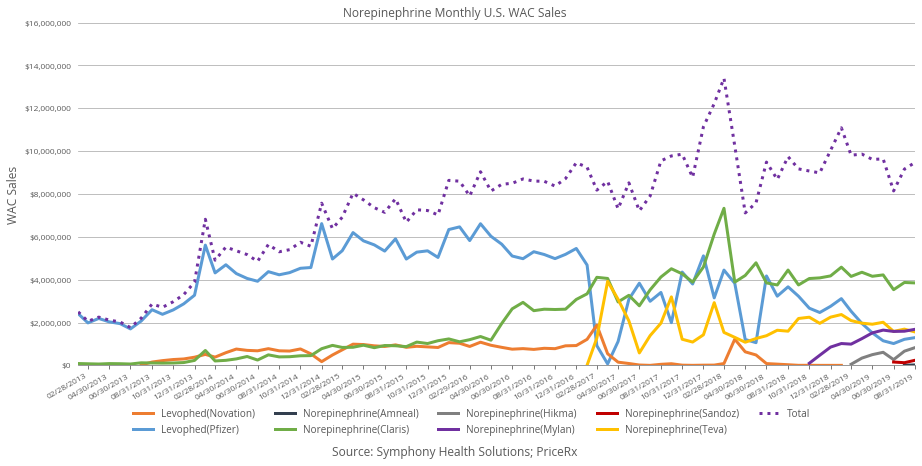

In [26]:
wac = calculated_df.pivot_table(index="Date", columns=["Drug", "Manufacturer"], values=UNITS["mbs"])
wac["Total"] = wac.sum(axis=1)

# Setting up figure and axes
fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(1, 1, 1)

# Plotting the data
# Need to make dynamic
levo_p = wac[("Levophed Bitartrate", "Pfizer")]
nor_h = wac[("Norepinephrine Bitartrate", "Hikma")]
levo_n = wac[("Levophed Bitartrate", "Novation")]
nor_a = wac[("Norepinephrine Bitartrate", "Amneal")]
nor_c = wac[("Norepinephrine Bitartrate", "Claris")]
nor_s = wac[("Norepinephrine Bitartrate", "Sandoz")]
nor_t = wac[("Norepinephrine Bitartrate", "Teva")]
total = wac["Total"]
nor_m = wac[("Norepinephrine Bitartrate", "Mylan")]

ax.plot(levo_p, c=adj_color_map["blue"], label="Levophed(Pfizer)")
ax.plot(nor_h, c=adj_color_map["grey"], label="Norepinephrine(Hikma)")
ax.plot(levo_n, c=adj_color_map["orange"], label="Levophed(Novation)")
ax.plot(nor_a, c=adj_color_map["blue-grey"], label="Norepinephrine(Amneal)")
ax.plot(nor_c, c=adj_color_map["green"], label="Norepinephrine(Claris)")
ax.plot(nor_s, c=adj_color_map["red"], label="Norepinephrine(Sandoz)")
ax.plot(nor_t, c=adj_color_map["yellow"], label="Norepinephrine(Teva)")
ax.plot(total, c=adj_color_map["purple"], ls="dotted", label="Total")
ax.plot(nor_m, c=adj_color_map["purple"], label="Norepinephrine(Mylan)")

# Formatting the y axis
ax.set_ylim([0, 16000000])
ax.yaxis.set_major_formatter(FuncFormatter(format_fn_wac))
ax.yaxis.grid(True)

# Formatting the x axis
ax.set_xticks(list(total.index)[::-2])
ax.set_xlim([total.index[0], total.index[-1]])
years_fmt = mdates.DateFormatter("%m/%d/%Y")
ax.xaxis.set_major_formatter(years_fmt)

# Removing spines and ticks (where necessary)
ax.spines["top"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["right"].set_visible(False)

# Adding labels and titles
ax.tick_params(left=False)
ax.set_title("Norepinephrine Monthly U.S. WAC Sales", size="large", position=(.45,1))
ax.set_xlabel("Source: Symphony Health Solutions; PriceRx", labelpad=45, position=(.45,1), size="medium")
ax.set_ylabel("WAC Sales", size="large")

# Reducing axis font and setting x spine color
ax.tick_params(axis='x', labelsize="small")
ax.tick_params(axis='y', labelsize="small")
ax.spines["bottom"].set_color('grey')

# Formatting the date labels
fig.autofmt_xdate()

# Organizing the legend
handles, labels = ax.get_legend_handles_labels()
h = sorted(zip(handles, labels), key=operator.itemgetter(1))
handles2, labels2 = zip(*h)

# Plotting the legend
ax.legend(handles2, labels2, loc="upper center", ncol=5, bbox_to_anchor=(.47,-0.10), frameon=False)

# Showing the plot
plt.show()
# plt.savefig("testerr.pdf")